In [1]:
from model_training.Model import RNNModel
from model_training.Trainer import RNNTrainer
from model_training.Dataset import NavigationDataset
import torch
import pandas as pd
from data_generation.Environment import Environment
from data_generation.Agent import Agent
import matplotlib.pyplot as plt
import pickle

In [ ]:
data = pd.read_csv("data/square_1000traj_50steps.csv")
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset = NavigationDataset(data)
dataloader = dataset.get_dataloader(batch_size=64, shuffle=True)
dataloader_iter = iter(dataloader)
# model = RNNModel(device=device)
with open("models/rnn_sq_model.pkl", "rb") as f:
    model = pickle.load(f)
model.to(device)
batch = next(dataloader_iter)
trainer = RNNTrainer(model, device=device)
trainer.train(dataloader, n_epochs=1000, verbose=True)
model.to("cpu")
with open("models/rnn_sq_model.pkl", "wb") as f:
    pickle.dump(model, f)

Epoch 499 | Total Loss: 0.020364 : 100%|██████████| 500/500 [4:02:05<00:00, 29.05s/it]  


In [21]:
with open("models/rnn_sq_model.pkl", "rb") as f:
    model = pickle.load(f)
print(len(model.loss_history[0]))

500


torch.Size([42, 100])


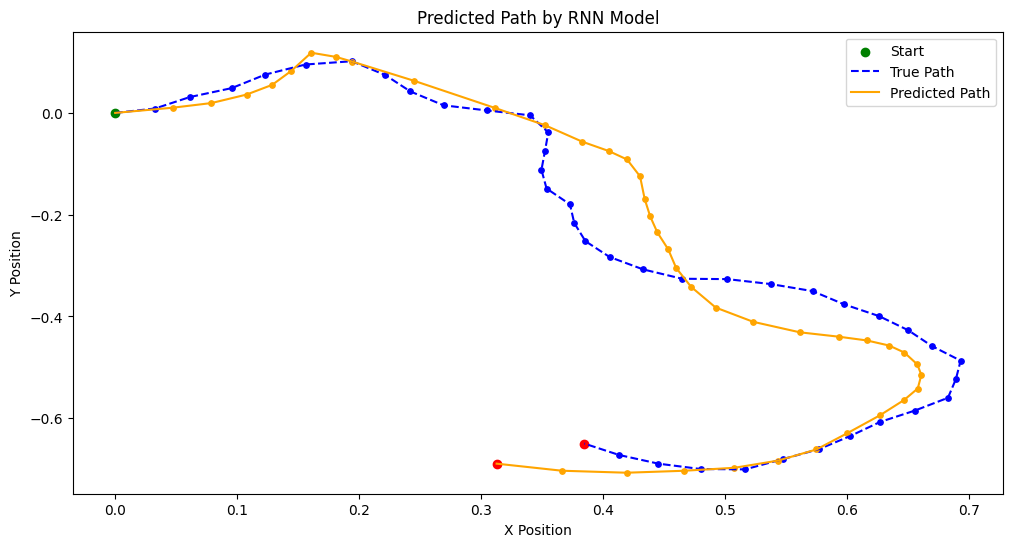

In [16]:

training_data = pd.read_csv("data/square_1000traj_50steps.csv")
training_data = training_data[training_data['run_id'] == 2]
training_data['run_id'] = 0
training_data = NavigationDataset(training_data)
with open("models/rnn_sq_model.pkl", "rb") as f:
    model = pickle.load(f)
env = Environment(4, 1, 1)
agent = Agent(env, kappa=10)
for _ in range(51):
    agent.step(1)

path = agent.get_data()
# print(path.head())
path['run_id'] = 0
data = NavigationDataset(path)

training_data_loader = training_data.get_dataloader(batch_size=1, shuffle=True)
# dataloader = data.get_dataloader(batch_size=1)

model.to("cpu")
model.device = "cpu"
# predict the sample data
model.eval()
outputs = []
activations = []
with torch.no_grad():
    for batch in training_data_loader:
        X, Y, lengths, run_ids = batch
        X = X[0]
        Y = Y[0]
        lengths = lengths[0]
        activations, outputs = model(X, lengths)
        break

print(activations.shape)
# agent.visualize_path()
# visualize the true path and predicted path

pred_path = outputs.numpy()
true_path = Y.numpy()
plt.figure(figsize=(12, 6))
plt.scatter(pred_path[0, 0], pred_path[0, 1], color='green', label='Start')
plt.plot(true_path[:, 0], true_path[:, 1], label='True Path', color='blue', linestyle='--')
plt.scatter(true_path[1:, 0], true_path[1:, 1], color='blue', s=15)
plt.plot(pred_path[:, 0], pred_path[:, 1], label='Predicted Path', color='orange')
plt.scatter(pred_path[1:, 0], pred_path[1:, 1], color='orange', s=15)
plt.scatter(pred_path[-1, 0], pred_path[-1, 1], color='red')
plt.scatter(true_path[-1, 0], true_path[-1, 1], color='red')
plt.title('Predicted Path by RNN Model')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()

            